<a href="https://colab.research.google.com/github/gerryfrank10/RL/blob/main/custom_dataset_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Custom Datasets
Pytorch has many existing functions to load various custom datasets including `TorchVision`, `TorchText`, `TorchAudio` and `TorchRec`

In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Getting Data
We are going to use `Food101 dataset` which is benchmark for computer vision and contains 1000 images of 101 different kinds of foods, totaling 101,000 images

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [11]:
!ls -lah data/pizza_steak_sushi/train/ # Each directory have images of each particular food

total 20K
drwxr-xr-x 5 root root 4.0K Mar 13 13:10 .
drwxr-xr-x 4 root root 4.0K Mar 13 13:10 ..
drwxr-xr-x 2 root root 4.0K Mar 13 13:10 pizza
drwxr-xr-x 2 root root 4.0K Mar 13 13:10 steak
drwxr-xr-x 2 root root 4.0K Mar 13 13:10 sushi


Our Goal is to take the directory structure and turn into a dataset usable with pytorch
1. The folders names are the labels for the images within that folder
2. Images in the folder are particular to all images within that folder/label

3699992.jpg
Image shape: (384, 512, 3)
Image class: pizza


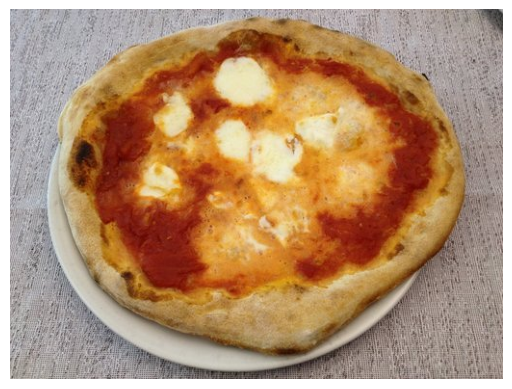

In [19]:
# Loading one image of pizza
import matplotlib.pyplot as plt
import cv2
import os
import random

random.seed(42)
random_pizza_image = random.choice(os.listdir('data/pizza_steak_sushi/train/pizza/'))
print(f'{random_pizza_image}')
random_pizza_image_path = 'data/pizza_steak_sushi/train/pizza/' + random_pizza_image
img = cv2.imread(random_pizza_image_path)[:,:,::-1] # Getting the image in rgb instead of grayscale
print(f'Image shape: {img.shape}') # Image H,W,C
image_class = random_pizza_image_path.split('/')[-2] # Getting the class name from the path
print(f'Image class: {image_class}')
plt.imshow(img)
plt.axis('off');

## Transforming data
There are so many libraries each for different class for vision is `torchvision.datasets`

In [20]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

`torchvision.transforms` contains prebuilt methods for data augmentation( the practice of altering data to make it harder for a model to learn) examples are
- Resize image from (512x512 to 64x64)
- Randomly Flip Image
- Turn Image from PIL to tensor

In [21]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5), # Probability of flipping is 50%
    transforms.ToTensor() # Convert all pixels from 0 to 255 to be btn 0.0 to 1.0
])

In [23]:
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
image_path_list = list(image_path.glob('*/*/*.jpg'))
print(image_path)
print(image_path_list[:5])

data/pizza_steak_sushi
[PosixPath('data/pizza_steak_sushi/train/sushi/2980779.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/2813454.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/794647.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/3360232.jpg'), PosixPath('data/pizza_steak_sushi/train/sushi/497686.jpg')]


In [28]:
from PIL import Image
def plot_transformed_image(image_path, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_path_list, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2, figsize=(10, 5))
      ax[0].imshow(f)
      ax[0].set_title(f'Original Size: \n{f.size}')
      ax[0].axis('off')

      # permute changes to the following
      # Pytorch default [C, H, W] but Matplotlib [H, W, C]

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed Size: \n{transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}')

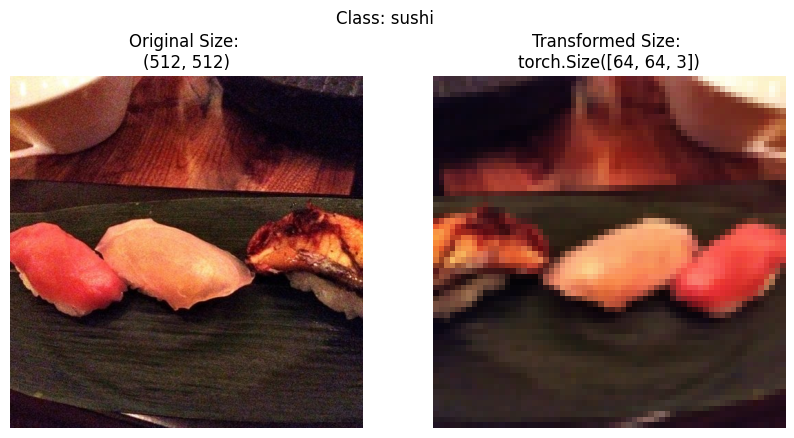

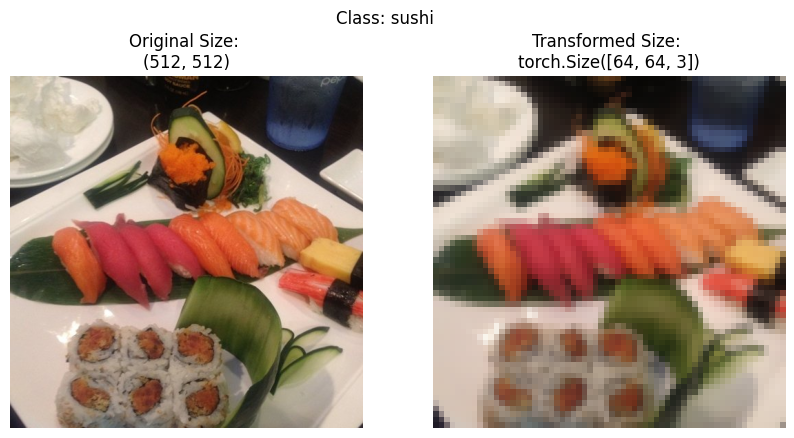

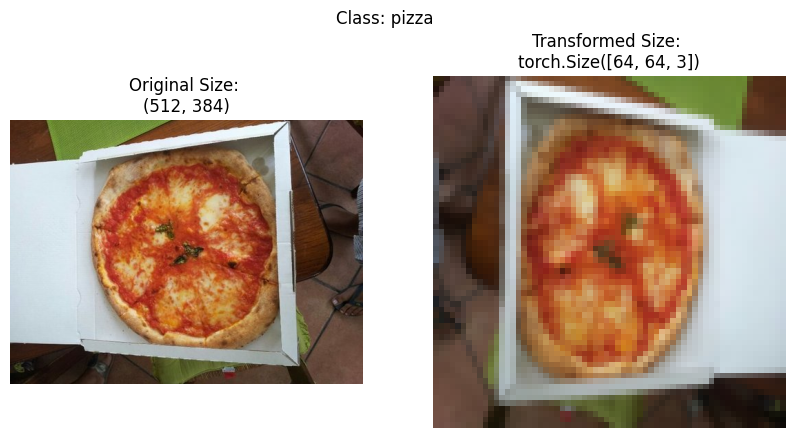

In [29]:
plot_transformed_image(image_path_list, data_transform)

## Loading Image Data Using `ImageFolder`

In [30]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)
print(f'train data:\n{train_data}\ntest data:\n{test_data}')

train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [31]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [33]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [34]:
len(train_data), len(test_data)

(225, 75)

In [35]:
type(train_data)

torchvision.datasets.folder.ImageFolder

In [53]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n{img}\nImage shape: {img.shape}\nImage datatype: {img.dtype}\nImage label: {label}\nLabel datatype: {type(label)}')

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original Image shape: torch.Size([3, 64, 64])
Permuted Image shape: torch.Size([64, 64, 3])


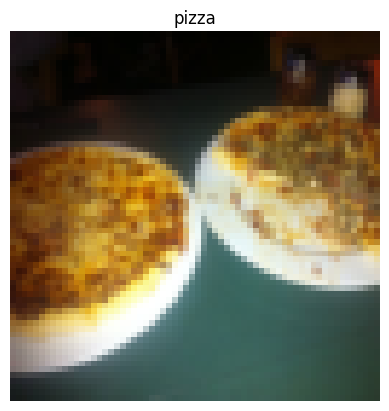

In [54]:
img_permute = img.permute(1, 2, 0)
print(f'Original Image shape: {img.shape}')
print(f'Permuted Image shape: {img_permute.shape}')
plt.imshow(img_permute)
plt.title(class_names[label])
plt.axis('off');

### Turn Image into DataLoader

In [55]:
# For num_workers we can use os.cpu_count() to determine how many workers we are using
print(os.cpu_count())

2


In [66]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=2, # How many samples per batch
    num_workers = 1,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=2,
    num_workers=1,
    shuffle=False
)
img, label = next(iter(train_dataloader)) # First 2 Image batch
print(f'Image Shape : {img.shape}')
print(f'Image Label : {label.shape}')

Image Shape : torch.Size([2, 3, 64, 64])
Image Label : torch.Size([2])


### Function to display Random images

In [68]:
# 1. Take in a Dataset as well as a list of class names
from typing import List
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

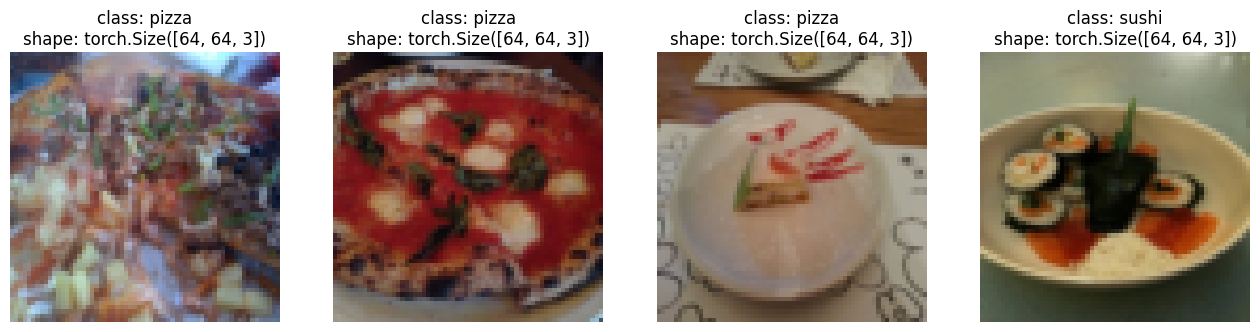

In [69]:
display_random_images(train_data, n=4, classes=class_names, seed=None)

## Other forms of transform (data augmentation)

**Data Augmentation** is the process of altering your data in such a way that you artificially increase the diversity of your training set.

Pytorch Team used *TrivialAugment* to train their state-of-the-art vision models


In [70]:
# Other transforms (data Augmentation)
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=30), # how many different levels of augmentation to use
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

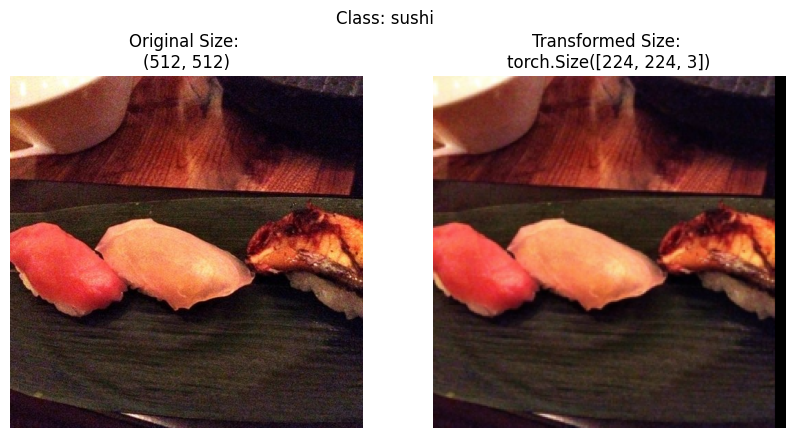

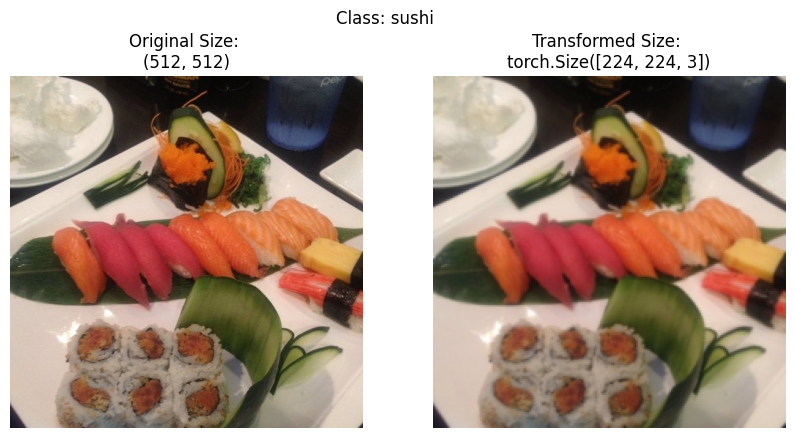

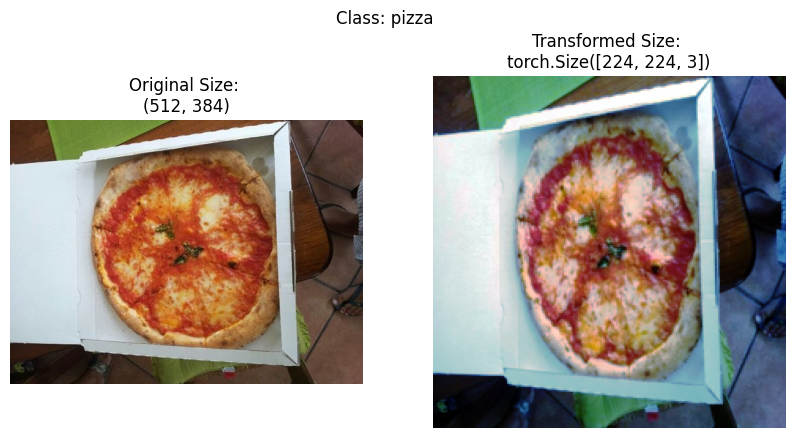

In [72]:
plot_transformed_image(image_path_list, transform=train_transforms)

## Model 0 : TinyVGG

In [73]:
# Our simple transform to resize image to (64, 64)
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [74]:
# Loading and transforming data
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
    target_transform=None
)
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform,
    target_transform=None
)
train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)
train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7e98d1670190>,
 <torch.utils.data.dataloader.DataLoader at 0x7e98d187be10>)

### TinyVGG Model

In [81]:
# Its same model expect now we are going to use color images
# so the in_channels = 3 and not grayscale which in_channels = 1
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x

In [82]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### Trying forward pass on single image

To do forward pass the following are the steps
1. Get batch of images and labels from dataloader
2. get single image from batch and `unsqueeze()` the image so it has batch size of 1
3. perform inference on a single image
4. print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` and use `torch.argmax()` to get prediction labels

In [83]:
img_batch, label = next(iter(train_dataloader_simple))

# Getting single image from the batch
img_single, label_single = img_batch[0].unsqueeze(dim=0), label[0]
print(f'Single Image Shape: {img_single.shape}')
print(f'Single Image Label: {label_single}')


Single Image Shape: torch.Size([1, 3, 64, 64])
Single Image Label: 2


In [84]:
# Perform forward pass
model_0.eval()
with torch.inference_mode():
  pred = model_0(img_single.to(device))
print(f'Output Logits : \n{pred}\n')


Output Logits : 
tensor([[0.0578, 0.0634, 0.0351]])



In [85]:
print(f'Output Probabilities : \n{torch.softmax(pred, dim=1)}\n')

Output Probabilities : 
tensor([[0.3352, 0.3371, 0.3277]])



In [87]:
print(f'Output prediction label :\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}')
print(f'Actual label : {label_single}')

Output prediction label :
tensor([1])
Actual label : 2


### using Torchinfo
to get the summary of the forward()

In [89]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### train test loop function